# 📚 Projet 10 : Application de recommandation de contenu

## 🎯 Contexte

My Content est une start-up qui souhaite encourager la lecture en recommandant des contenus pertinents à ses utilisateurs. En tant que CTO et cofondateur avec Samia (CEO), nous développons un premier MVP sous forme d'application de recommandation d'articles et de livres.

## 🚀 Objectifs du projet

### 🎪 Fonctionnalité critique identifiée
**User Story principale :** "En tant qu'utilisateur de l'application, je vais recevoir une sélection de cinq articles."

### ⚡ Défis techniques
- Absence de données utilisateurs propres → utilisation de données disponibles en ligne
- Prise en compte future de l'ajout de nouveaux utilisateurs et nouveaux articles dans l'architecture cible

## 🏗️ Architecture technique recommandée

D'après les conseils de Julien (développeur web freelance), deux architectures serverless sont envisageables avec Azure Functions :

1. **🔌 Architecture avec API** : Création d'une API pour développer et exposer le système de recommandation, avec Azure Functions comme interface
2. **⚡ Architecture directe** : Intégration directe des prédictions dans Azure Functions avec Azure Blob storage input binding pour récupérer fichiers et modèles

## 📊 Données disponibles

- **📋 articles_metadata.csv** : Métadonnées des articles (ID, catégorie, nombre de mots, etc.)
- **👆 clicks.csv / clicks_sample.csv** : Interactions utilisateurs avec les articles. Comme nous sommes dans un projet minimal viable (MVP), nous nous contenterons de **clicks_sample.csv**
- **🧠 articles_embeddings.pickle** : Représentations vectorielles des articles (réduction dimensionnelle possible via ACP si trop volumineux)

## 📦 Livrables attendus

1. **🤖 Système de recommandation** sous forme d'Azure Functions
2. **💻 Application simple** avec interface de gestion :
   - Liste des ID utilisateurs
   - Appel des Azure Functions pour l'utilisateur sélectionné  
   - Affichage des 5 articles recommandés
3. **🐙 Stockage GitHub** des scripts développés
4. **📋 Synthèse technique** comprenant :
   - Architecture technique actuelle et description fonctionnelle
   - Architecture cible pour la prise en compte de nouveaux utilisateurs/articles
   - Présentation des recommandations à Samia

## 🛠️ Approche de développement

Ce projet suit une logique MVP avec focus sur la fonctionnalité critique tout en préparant l'évolutivité de la solution pour les besoins futurs de la start-up.

In [1]:
!pip install "numpy<2.0" --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!pip install scikit-surprise --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [60]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
from surprise import Dataset, Reader, SVD, accuracy, dump
from surprise.model_selection import train_test_split as surprise_train_test_split
warnings.filterwarnings('ignore')

print("🚀 Projet 10 - Application de recommandation de contenu")
print("=" * 60)

🚀 Projet 10 - Application de recommandation de contenu


# I. Setup et chargement des données

In [3]:
# 1. Montage Google Drive et navigation
from google.colab import drive
drive.mount('/content/drive')
import os
import zipfile

# Accès au dossier du projet 10
drive_folder = "/content/drive/MyDrive/Colab_Notebooks/Project_10/"
os.chdir(drive_folder)
print(f"📁 Contenu du dossier: {os.listdir()}")

Mounted at /content/drive
📁 Contenu du dossier: ['news-portal-user-interactions-by-globocom.zip', 'p10_notebook.ipynb']


In [4]:
# 2. Décompression des données
zip_path = "news-portal-user-interactions-by-globocom.zip"
extract_path = "/content/data"

print("📦 Décompression des données principales...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✅ Données extraites dans: {extract_path}")
print(f"📂 Fichiers extraits: {os.listdir(extract_path)}")

# Décompression du clicks.zip si présent
clicks_zip_path = os.path.join(extract_path, "clicks.zip")
if os.path.exists(clicks_zip_path):
    print("📦 Décompression de clicks.zip...")
    with zipfile.ZipFile(clicks_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ clicks.csv décompressé")
    print(f"📂 Fichiers finaux: {os.listdir(extract_path)}")
else:
    print("⚠️ clicks.zip non trouvé")

📦 Décompression des données principales...
✅ Données extraites dans: /content/data
📂 Fichiers extraits: ['clicks.zip', 'articles_embeddings.pickle', 'clicks_sample.csv', 'articles_metadata.csv']
📦 Décompression de clicks.zip...
✅ clicks.csv décompressé
📂 Fichiers finaux: ['clicks.zip', 'articles_embeddings.pickle', 'clicks_sample.csv', 'articles_metadata.csv', 'clicks']


In [5]:
# 3. Définition du chemin des données
data_path = "/content/data"

# 4. Chargement des fichiers
print("📂 Chargement des fichiers...")

# Chargement des clics (interactions utilisateur-article)
try:
    clicks_df = pd.read_csv(f"{data_path}/clicks_sample.csv")
    print(f"✅ Clicks sample chargés: {clicks_df.shape}")
    print("💡 Utilisation de l'échantillon pour le développement du MVP")
except Exception as e:
    print(f"❌ Erreur clicks_sample.csv: {e}")

# Chargement des métadonnées articles
try:
    articles_df = pd.read_csv(f"{data_path}/articles_metadata.csv")
    print(f"✅ Articles metadata chargés: {articles_df.shape}")
except Exception as e:
    print(f"❌ Erreur articles_metadata.csv: {e}")

# Chargement des embeddings
try:
    with open(f"{data_path}/articles_embeddings.pickle", 'rb') as f:
        embeddings = pickle.load(f)
    print(f"✅ Embeddings chargés: {embeddings.shape}")
except Exception as e:
    print(f"❌ Erreur articles_embeddings.pickle: {e}")


📂 Chargement des fichiers...
✅ Clicks sample chargés: (1883, 12)
💡 Utilisation de l'échantillon pour le développement du MVP
✅ Articles metadata chargés: (364047, 5)
✅ Embeddings chargés: (364047, 250)


🔍 Exploration générale:

📊 CLICKS DATA:
Shape: (1883, 15)
Colonnes: ['user_id', 'session_id', 'session_start', 'session_size', 'click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type', 'datetime', 'hour', 'date']
Période: 2017-10-01 03:00:00.026000 - 2017-10-03 02:35:54.157000

📈 Statistiques générales:
- Utilisateurs uniques: 707
- Articles uniques cliqués: 323
- Interactions totales: 1883
- Interactions par utilisateur (moyenne): 2.66

📊 Distribution interactions par utilisateur:
- Min: 2
- Médiane: 2.0
- Moyenne: 2.66
- Max: 24

📈 Visualisation 1: Distribution des interactions par utilisateur
📂 Source: clicks_sample.csv (1883 interactions)
🔍 Périmètre: Échantillon de 707 utilisateurs sur 47h35min


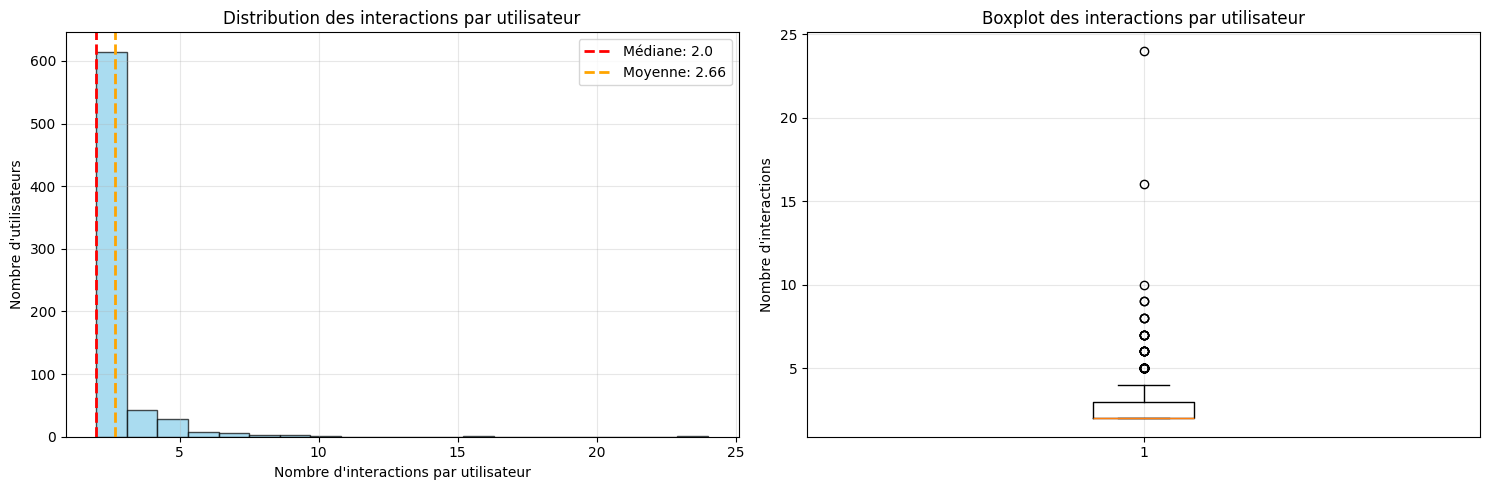


📈 Visualisation 2: Articles les plus populaires
📂 Source: clicks_sample.csv (1883 interactions)
🔍 Périmètre: Popularité basée sur l'échantillon de 47h35min


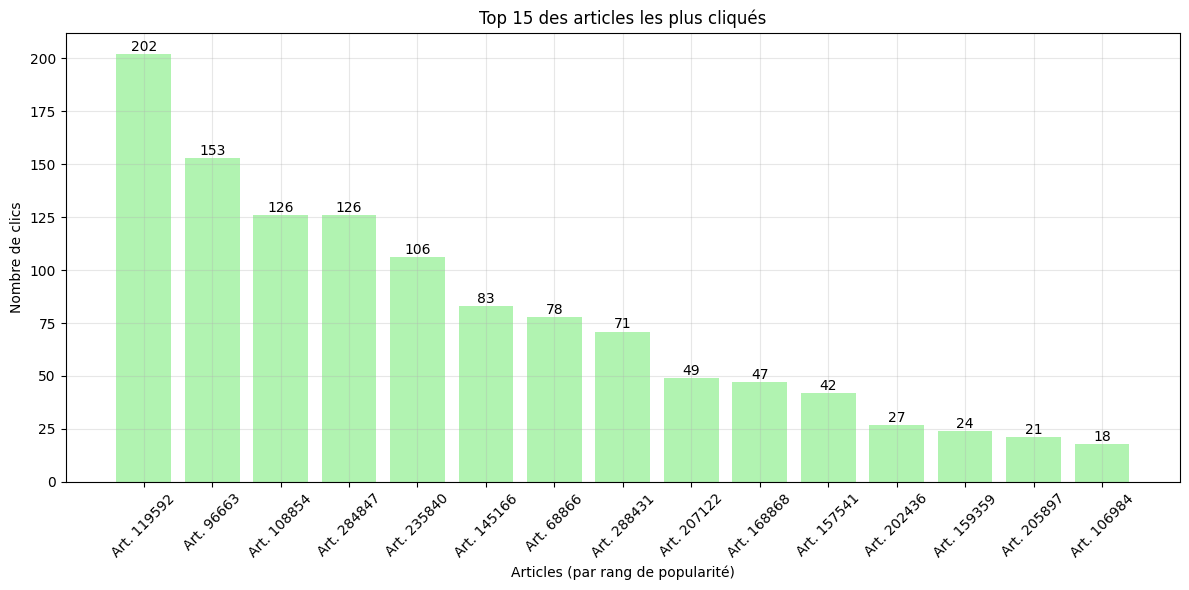

📊 Top 5 des articles les plus cliqués:
  1. Article 119592: 202 clics
  2. Article 96663: 153 clics
  3. Article 108854: 126 clics
  4. Article 284847: 126 clics
  5. Article 235840: 106 clics

⏱️ Note temporelle:
Dataset couvre seulement 47h35min (1-3 oct 2017)
Période trop courte pour analyser des patterns temporels significatifs

📰 ARTICLES METADATA:
Shape: (364047, 6)
Colonnes: ['article_id', 'category_id', 'created_at_ts', 'publisher_id', 'words_count', 'year']

📈 Visualisation 3: Analyse des métadonnées
📂 Source: articles_metadata.csv (364047 articles)
🔍 Périmètre: Exhaustif - TOUS les articles du catalogue (2006-2018)


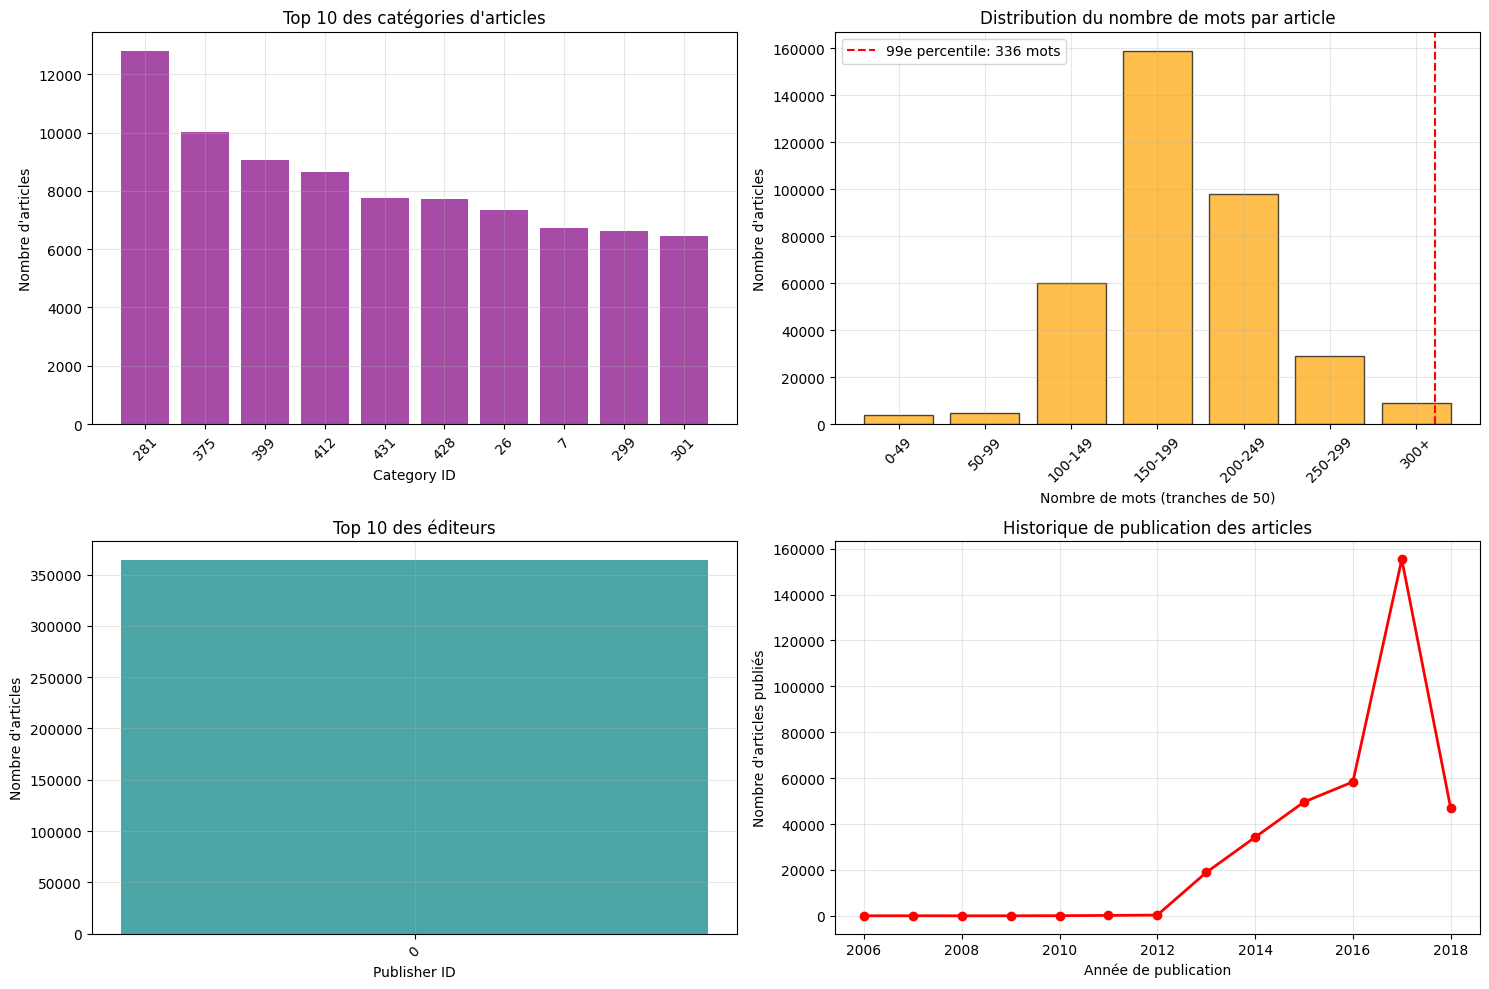

📊 Statistiques des métadonnées:
- Catégories uniques: 461
- Éditeurs uniques: 1
- Nombre de mots médian: 186
- Période de publication: 2006 - 2018

📈 Visualisation 4: Sparsité des données
📂 Source: clicks_sample.csv + articles_metadata.csv
🔍 Périmètre: Matrice 707 utilisateurs × 323 articles cliqués (échantillon)
⚠️ Note: Heatmap limitée à un échantillon 50×50 pour lisibilité


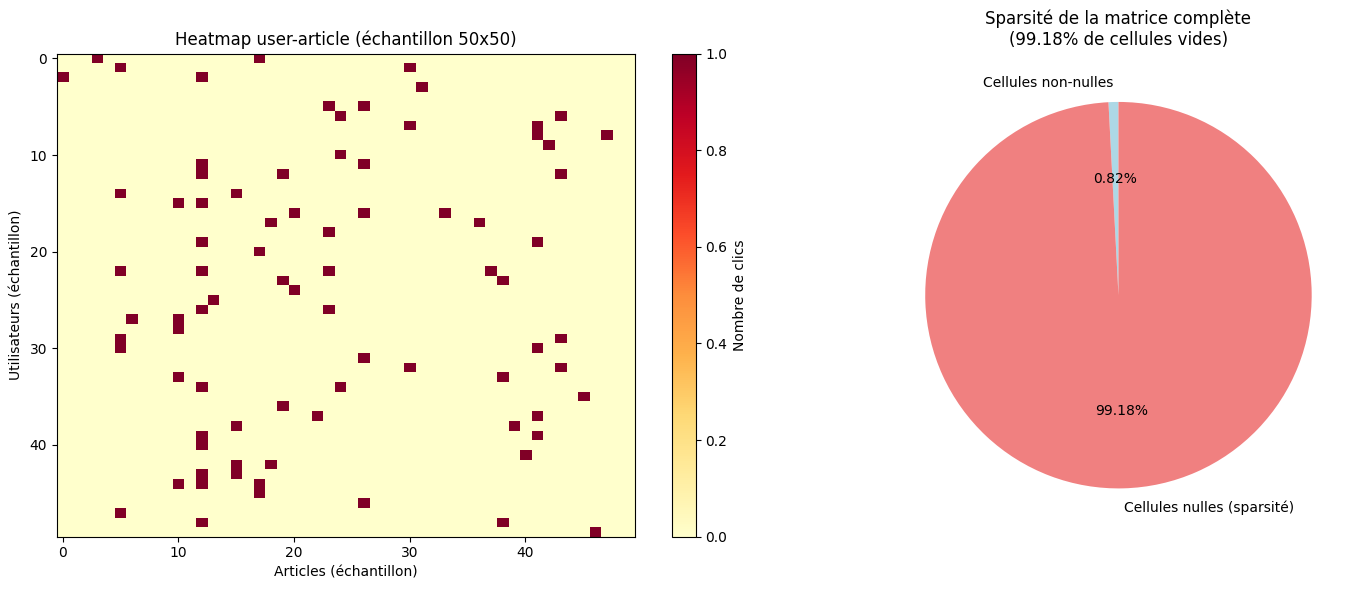

📊 Métriques de sparsité:
- Matrice user-article: (707, 323)
- Cellules totales: 228,361
- Cellules non-nulles: 1,883
- Sparsité: 99.18%

🎯 EXPLICATION DE LA SPARSITÉ:
La sparsité mesure le pourcentage de cellules vides dans une matrice.
Dans le contexte des systèmes de recommandation:
- Matrice user-item: lignes = utilisateurs, colonnes = articles
- Cellule (i,j) = nombre d'interactions entre utilisateur i et article j
- Sparsité = % de cellules à 0 (pas d'interaction)

Ici, 99.18% de sparsité signifie que:
- La plupart des utilisateurs n'ont pas interagi avec la plupart des articles
- C'est typique des systèmes de recommandation réels
- Rend le collaborative filtering difficile (peu de données communes)
- Justifie l'approche content-based (utilise les caractéristiques des articles)

🔗 Vérification alignement données:
- Articles metadata: 364047 articles
- Embeddings: 364047 articles
- Articles avec clics: 323
- Range article_id: 0 - 364046
✅ Alignement article_id <-> embeddings confir

In [50]:
# 5. Exploration générale des données avec visualisations
print("🔍 Exploration générale:")

if 'clicks_df' in locals():
    print(f"\n📊 CLICKS DATA:")
    print(f"Shape: {clicks_df.shape}")
    print(f"Colonnes: {list(clicks_df.columns)}")
    print(f"Période: {pd.to_datetime(clicks_df['click_timestamp'], unit='ms').min()} - {pd.to_datetime(clicks_df['click_timestamp'], unit='ms').max()}")

    # Statistiques de base
    n_users = clicks_df['user_id'].nunique()
    n_articles_clicked = clicks_df['click_article_id'].nunique()
    n_interactions = len(clicks_df)

    print(f"\n📈 Statistiques générales:")
    print(f"- Utilisateurs uniques: {n_users}")
    print(f"- Articles uniques cliqués: {n_articles_clicked}")
    print(f"- Interactions totales: {n_interactions}")
    print(f"- Interactions par utilisateur (moyenne): {n_interactions/n_users:.2f}")

    # Distribution des interactions par utilisateur
    user_interactions = clicks_df['user_id'].value_counts()
    print(f"\n📊 Distribution interactions par utilisateur:")
    print(f"- Min: {user_interactions.min()}")
    print(f"- Médiane: {user_interactions.median()}")
    print(f"- Moyenne: {user_interactions.mean():.2f}")
    print(f"- Max: {user_interactions.max()}")

    # VISUALISATION 1: Distribution des interactions par utilisateur
    print("\n📈 Visualisation 1: Distribution des interactions par utilisateur")
    print(f"📂 Source: clicks_sample.csv ({clicks_df.shape[0]} interactions)")
    print(f"🔍 Périmètre: Échantillon de {n_users} utilisateurs sur 47h35min")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Histogramme
    ax1.hist(user_interactions.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(user_interactions.median(), color='red', linestyle='--', linewidth=2, label=f'Médiane: {user_interactions.median()}')
    ax1.axvline(user_interactions.mean(), color='orange', linestyle='--', linewidth=2, label=f'Moyenne: {user_interactions.mean():.2f}')
    ax1.set_xlabel('Nombre d\'interactions par utilisateur')
    ax1.set_ylabel('Nombre d\'utilisateurs')
    ax1.set_title('Distribution des interactions par utilisateur')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Boxplot
    ax2.boxplot(user_interactions.values, vert=True)
    ax2.set_ylabel('Nombre d\'interactions')
    ax2.set_title('Boxplot des interactions par utilisateur')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # VISUALISATION 2: Top articles les plus cliqués
    print("\n📈 Visualisation 2: Articles les plus populaires")
    print(f"📂 Source: clicks_sample.csv ({clicks_df.shape[0]} interactions)")
    print(f"🔍 Périmètre: Popularité basée sur l'échantillon de 47h35min")

    article_popularity = clicks_df['click_article_id'].value_counts().head(15)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(article_popularity)), article_popularity.values, color='lightgreen', alpha=0.7)
    plt.xlabel('Articles (par rang de popularité)')
    plt.ylabel('Nombre de clics')
    plt.title('Top 15 des articles les plus cliqués')
    plt.xticks(range(len(article_popularity)), [f'Art. {id}' for id in article_popularity.index], rotation=45)

    # Ajouter les valeurs sur les barres
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{int(height)}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"📊 Top 5 des articles les plus cliqués:")
    for i, (article_id, count) in enumerate(article_popularity.head().items(), 1):
        print(f"  {i}. Article {article_id}: {count} clics")

    # Note sur la période temporelle
    print(f"\n⏱️ Note temporelle:")
    print(f"Dataset couvre seulement 47h35min (1-3 oct 2017)")
    print(f"Période trop courte pour analyser des patterns temporels significatifs")

if 'articles_df' in locals():
    print(f"\n📰 ARTICLES METADATA:")
    print(f"Shape: {articles_df.shape}")
    print(f"Colonnes: {list(articles_df.columns)}")

    # VISUALISATION 3: Métadonnées des articles
    print("\n📈 Visualisation 3: Analyse des métadonnées")
    print(f"📂 Source: articles_metadata.csv ({articles_df.shape[0]} articles)")
    print(f"🔍 Périmètre: Exhaustif - TOUS les articles du catalogue (2006-2018)")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Distribution des catégories
    category_counts = articles_df['category_id'].value_counts().head(10)
    ax1.bar(range(len(category_counts)), category_counts.values, color='purple', alpha=0.7)
    ax1.set_xlabel('Category ID')
    ax1.set_ylabel('Nombre d\'articles')
    ax1.set_title('Top 10 des catégories d\'articles')
    ax1.set_xticks(range(len(category_counts)))
    ax1.set_xticklabels(category_counts.index, rotation=45)
    ax1.grid(True, alpha=0.3)

    # Distribution du nombre de mots - version avec continuité
    words_count = articles_df['words_count']

    # PARAMÈTRES CONFIGURABLES
    percentile_threshold = 99  # Seuil pour la dernière catégorie
    bin_size = 50  # Taille des tranches

    # Calculs basés sur les paramètres
    threshold_value = np.percentile(words_count, percentile_threshold)

    # Créer les bins avec continuité jusqu'au seuil
    max_regular_bin = int(threshold_value // bin_size) * bin_size
    bins = list(range(0, max_regular_bin + bin_size, bin_size))
    bins.append(words_count.max())  # Borne supérieure finale

    # Créer les labels avec continuité
    labels = []
    for i in range(len(bins) - 1):
        start = bins[i]
        if i == len(bins) - 2:  # Dernière catégorie
            labels.append(f'{start}+')
        else:
            end = bins[i+1] - 1
            labels.append(f'{start}-{end}')

    # Catégoriser les données
    words_categorized = pd.cut(words_count, bins=bins, labels=labels, include_lowest=True)
    category_counts_words = words_categorized.value_counts().sort_index()

    # Créer le graphique
    bars = ax2.bar(range(len(category_counts_words)), category_counts_words.values, alpha=0.7, color='orange', edgecolor='black')

    # Position du trait pointillé dans la dernière barre
    last_bar_index = len(category_counts_words) - 1
    last_bar_start = bins[-2]  # Début de la dernière catégorie
    last_bar_width = threshold_value - last_bar_start

    # Position relative du percentile dans la dernière barre (0 = début, 1 = fin)
    relative_position = last_bar_width / bin_size if last_bar_width <= bin_size else 1
    line_position = last_bar_index + relative_position - 0.5

    # Ajouter le trait pointillé
    ax2.axvline(line_position, color='red', linestyle='--',
               label=f'{percentile_threshold}e percentile: {threshold_value:.0f} mots')

    ax2.set_xlabel(f'Nombre de mots (tranches de {bin_size})')
    ax2.set_ylabel('Nombre d\'articles')
    ax2.set_title('Distribution du nombre de mots par article')
    ax2.set_xticks(range(len(category_counts_words)))
    ax2.set_xticklabels(labels, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Distribution des publishers
    publisher_counts = articles_df['publisher_id'].value_counts().head(10)
    ax3.bar(range(len(publisher_counts)), publisher_counts.values, color='teal', alpha=0.7)
    ax3.set_xlabel('Publisher ID')
    ax3.set_ylabel('Nombre d\'articles')
    ax3.set_title('Top 10 des éditeurs')
    ax3.set_xticks(range(len(publisher_counts)))
    ax3.set_xticklabels(publisher_counts.index, rotation=45)
    ax3.grid(True, alpha=0.3)

    # Articles par année (basé sur created_at_ts) - PERTINENT car historique de publication
    articles_df['year'] = pd.to_datetime(articles_df['created_at_ts'], unit='ms').dt.year
    year_counts = articles_df['year'].value_counts().sort_index()
    ax4.plot(year_counts.index, year_counts.values, marker='o', linewidth=2, markersize=6, color='red')
    ax4.set_xlabel('Année de publication')
    ax4.set_ylabel('Nombre d\'articles publiés')
    ax4.set_title('Historique de publication des articles')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"📊 Statistiques des métadonnées:")
    print(f"- Catégories uniques: {articles_df['category_id'].nunique()}")
    print(f"- Éditeurs uniques: {articles_df['publisher_id'].nunique()}")
    print(f"- Nombre de mots médian: {articles_df['words_count'].median():.0f}")
    print(f"- Période de publication: {articles_df['year'].min()} - {articles_df['year'].max()}")

    # VISUALISATION 4: Sparsité de la matrice user-item
    print("\n📈 Visualisation 4: Sparsité des données")
    print(f"📂 Source: clicks_sample.csv + articles_metadata.csv")
    print(f"🔍 Périmètre: Matrice {n_users} utilisateurs × {n_articles_clicked} articles cliqués (échantillon)")
    print(f"⚠️ Note: Heatmap limitée à un échantillon 50×50 pour lisibilité")

    # Créer une matrice user-article échantillonnée pour visualisation
    user_article_sample = clicks_df.groupby(['user_id', 'click_article_id']).size().unstack(fill_value=0)

    # Prendre un échantillon pour la visualisation (premiers 50 users et 50 articles les plus populaires)
    top_articles = clicks_df['click_article_id'].value_counts().head(50).index
    sample_users = user_article_sample.index[:50]
    sample_matrix = user_article_sample.loc[sample_users, user_article_sample.columns.intersection(top_articles)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Heatmap de sparsité
    im1 = ax1.imshow(sample_matrix.values, cmap='YlOrRd', aspect='auto')
    ax1.set_xlabel('Articles (échantillon)')
    ax1.set_ylabel('Utilisateurs (échantillon)')
    ax1.set_title('Heatmap user-article (échantillon 50x50)')
    plt.colorbar(im1, ax=ax1, label='Nombre de clics')

    # Statistiques de sparsité
    total_cells = user_article_sample.shape[0] * user_article_sample.shape[1]
    non_zero_cells = np.count_nonzero(user_article_sample.values)
    sparsity = (1 - non_zero_cells / total_cells) * 100

    # Graphique de sparsité
    labels = ['Cellules non-nulles', 'Cellules nulles (sparsité)']
    sizes = [non_zero_cells, total_cells - non_zero_cells]
    colors = ['lightblue', 'lightcoral']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
    ax2.set_title(f'Sparsité de la matrice complète\n({sparsity:.2f}% de cellules vides)')

    plt.tight_layout()
    plt.show()

    print(f"📊 Métriques de sparsité:")
    print(f"- Matrice user-article: {user_article_sample.shape}")
    print(f"- Cellules totales: {total_cells:,}")
    print(f"- Cellules non-nulles: {non_zero_cells:,}")
    print(f"- Sparsité: {sparsity:.2f}%")

    print(f"\n🎯 EXPLICATION DE LA SPARSITÉ:")
    print(f"La sparsité mesure le pourcentage de cellules vides dans une matrice.")
    print(f"Dans le contexte des systèmes de recommandation:")
    print(f"- Matrice user-item: lignes = utilisateurs, colonnes = articles")
    print(f"- Cellule (i,j) = nombre d'interactions entre utilisateur i et article j")
    print(f"- Sparsité = % de cellules à 0 (pas d'interaction)")
    print(f"")
    print(f"Ici, {sparsity:.2f}% de sparsité signifie que:")
    print(f"- La plupart des utilisateurs n'ont pas interagi avec la plupart des articles")
    print(f"- C'est typique des systèmes de recommandation réels")
    print(f"- Rend le collaborative filtering difficile (peu de données communes)")
    print(f"- Justifie l'approche content-based (utilise les caractéristiques des articles)")

    # Vérification alignement avec embeddings
    if 'embeddings' in locals():
        print(f"\n🔗 Vérification alignement données:")
        print(f"- Articles metadata: {len(articles_df)} articles")
        print(f"- Embeddings: {embeddings.shape[0]} articles")
        print(f"- Articles avec clics: {n_articles_clicked}")

        # Test alignement article_id <-> index embeddings
        max_article_id = articles_df['article_id'].max()
        min_article_id = articles_df['article_id'].min()
        print(f"- Range article_id: {min_article_id} - {max_article_id}")

        if max_article_id == embeddings.shape[0] - 1 and min_article_id == 0:
            print("✅ Alignement article_id <-> embeddings confirmé")
        else:
            print("⚠️ Vérifier l'alignement article_id <-> embeddings")

print("\n" + "="*60)

# II. Content-based Filtering

**Principe :** Recommande des articles similaires à ceux que l'utilisateur a déjà consultés, en se basant sur les caractéristiques du contenu des articles.

**Fonctionnement général :**
1. **Représentation du contenu** : Chaque article est représenté par un vecteur numérique (embedding) qui encode ses caractéristiques sémantiques
2. **Profil utilisateur** : Basé sur les embeddings des articles déjà consultés par l'utilisateur
3. **Calcul de similarité** : Mesure la proximité (similarité cosinus) entre le profil utilisateur et tous les autres articles
4. **Recommandation** : Sélectionne les articles les plus similaires non encore consultés

**Implémentation technique :**
- Utilise des embeddings pré-calculés (250 dimensions par article)
- Calculs de distance vectorielle pure (pas d'apprentissage en temps réel)
- Stratégies : dernier article vu, moyenne des articles vus, ou sélection aléatoire

**Avantages :**
- Fonctionne dès le premier clic de l'utilisateur
- Pas de problème de démarrage à froid pour les nouveaux articles
- Recommandations explicables et transparentes

**Inconvénients :**
- Risque de "bulle de filtre" (recommandations trop similaires)
- Dépend de la qualité de la représentation du contenu
- Difficulté à découvrir des contenus différents

In [51]:
# 1. Analyse spécifique Content-Based
print("\n🔍 Analyse spécifique pour Content-Based:")

if 'embeddings' in locals():
    print(f"✅ Embeddings disponibles: {embeddings.shape}")
    print(f"- Dimensions: {embeddings.shape[1]} features par article")
    print(f"- Type: {embeddings.dtype}")
    print(f"- Taille mémoire: ~{embeddings.nbytes / (1024**2):.1f} MB")

    # Vérification de la qualité des embeddings
    print(f"\n📊 Qualité des embeddings:")
    print(f"- Valeurs nulles: {np.isnan(embeddings).sum()}")
    print(f"- Valeurs infinies: {np.isinf(embeddings).sum()}")
    print(f"- Range des valeurs: [{embeddings.min():.3f}, {embeddings.max():.3f}]")


🔍 Analyse spécifique pour Content-Based:
✅ Embeddings disponibles: (364047, 250)
- Dimensions: 250 features par article
- Type: float32
- Taille mémoire: ~347.2 MB

📊 Qualité des embeddings:
- Valeurs nulles: 0
- Valeurs infinies: 0
- Range des valeurs: [-0.999, 0.998]


In [52]:
# 2. Préparation des données pour Content-Based
def prepare_content_based_data(clicks_df, embeddings):
    """
    Prépare les données pour le content-based filtering
    """
    print("🔧 Création de la structure de données...")

    # Créer un dictionnaire: user_id -> liste des articles cliqués
    user_articles = {}
    for _, row in clicks_df.iterrows():
        user_id = row['user_id']
        article_id = row['click_article_id']

        if user_id not in user_articles:
            user_articles[user_id] = []
        user_articles[user_id].append(article_id)

    print(f"✅ Structure créée pour {len(user_articles)} utilisateurs")

    # Statistiques sur les articles par utilisateur
    articles_per_user = [len(articles) for articles in user_articles.values()]
    print(f"📊 Articles par utilisateur:")
    print(f"- Min: {min(articles_per_user)}")
    print(f"- Médiane: {np.median(articles_per_user)}")
    print(f"- Moyenne: {np.mean(articles_per_user):.2f}")
    print(f"- Max: {max(articles_per_user)}")

    return user_articles

if 'clicks_df' in locals() and 'embeddings' in locals():
    user_articles_dict = prepare_content_based_data(clicks_df, embeddings)

🔧 Création de la structure de données...
✅ Structure créée pour 707 utilisateurs
📊 Articles par utilisateur:
- Min: 2
- Médiane: 2.0
- Moyenne: 2.66
- Max: 24


In [54]:
# 3. Développement du modèle Content-Based
def content_based_recommender(user_id, user_articles_dict, embeddings, n_recommendations=5, strategy='last'):
    """
    Système de recommandation basé sur le contenu

    Args:
        user_id: ID de l'utilisateur
        user_articles_dict: Dict {user_id: [article_ids]}
        embeddings: Matrice des embeddings articles
        n_recommendations: Nombre de recommandations
        strategy: 'last', 'random', 'mean'

    Returns:
        Liste des article_ids recommandés avec scores
    """

    if user_id not in user_articles_dict:
        print(f"❌ Utilisateur {user_id} non trouvé")
        return []

    clicked_articles = user_articles_dict[user_id]
    print(f"👤 Utilisateur {user_id} - {len(clicked_articles)} articles cliqués")

    # Vérifier que les articles existent dans les embeddings
    valid_articles = [art for art in clicked_articles if art < len(embeddings)]
    if not valid_articles:
        print("❌ Aucun article valide trouvé dans les embeddings")
        return []

    print(f"✅ {len(valid_articles)} articles valides pour le calcul")

    # Stratégies pour choisir l'embedding de référence
    if strategy == 'last':
        # Prendre le dernier article cliqué
        reference_article = valid_articles[-1]
        reference_embedding = embeddings[reference_article].reshape(1, -1)
        print(f"📰 Stratégie 'last': article {reference_article}")

    elif strategy == 'random':
        # Prendre un article au hasard
        reference_article = np.random.choice(valid_articles)
        reference_embedding = embeddings[reference_article].reshape(1, -1)
        print(f"🎲 Stratégie 'random': article {reference_article}")

    elif strategy == 'mean':
        # Moyenne des embeddings des articles cliqués
        articles_embeddings = embeddings[valid_articles]
        reference_embedding = np.mean(articles_embeddings, axis=0).reshape(1, -1)
        print(f"📊 Stratégie 'mean': moyenne de {len(valid_articles)} articles")

    # Calculer similarité cosinus (angle entre deux vecteurs de dimension N) avec tous les articles
    # Plus la similarité cosinus a une valeur élevée, plus la similarité entre 1 article et le "profil" de l'utilisateur
    #    (caractérisé par un ou plusieurs articles) est importante
    similarities = cosine_similarity(reference_embedding, embeddings)[0]

    # Créer liste des candidats (exclure articles déjà cliqués)
    candidates = []
    for article_id, similarity in enumerate(similarities):
        if article_id not in clicked_articles:  # Exclure articles déjà vus
            candidates.append((article_id, similarity))

    # Trier par similarité décroissante
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Retourner top N recommandations
    recommendations = candidates[:n_recommendations]

    print(f"✅ {len(recommendations)} recommandations générées")
    if recommendations:
        scores = [sim for _, sim in recommendations]
        print(f"📊 Scores de similarité: [{scores[0]:.3f} - {scores[-1]:.3f}]")

    return recommendations

In [55]:
# 4. Tests du modèle Content-Based
print("🧪 Tests du modèle Content-Based:")

def test_content_based_strategies():
    """
    Teste les différentes stratégies du content-based filtering
    """
    if 'user_articles_dict' not in globals() or 'embeddings' not in globals():
        print("❌ Données non préparées")
        return

    # Choisir un utilisateur test
    test_users = list(user_articles_dict.keys())[:3]  # 3 premiers utilisateurs

    strategies = ['last', 'mean', 'random']

    for user_id in test_users:
        print(f"\n👤 TEST UTILISATEUR {user_id}:")
        print(f"Articles cliqués: {user_articles_dict[user_id]}")

        for strategy in strategies:
            print(f"\n  🔄 Stratégie: {strategy}")
            recommendations = content_based_recommender(
                user_id, user_articles_dict, embeddings,
                n_recommendations=5, strategy=strategy
            )

            if recommendations:
                print(f"  📋 Recommandations:")
                for i, (article_id, score) in enumerate(recommendations, 1):
                    print(f"    {i}. Article {article_id} (score: {score:.3f})")
            print("  " + "-"*30)

if 'user_articles_dict' in globals() and 'embeddings' in globals():
    test_content_based_strategies()

print("\n" + "="*60)

🧪 Tests du modèle Content-Based:

👤 TEST UTILISATEUR 0:
Articles cliqués: [157541, 68866]

  🔄 Stratégie: last
👤 Utilisateur 0 - 2 articles cliqués
✅ 2 articles valides pour le calcul
📰 Stratégie 'last': article 68866
✅ 5 recommandations générées
📊 Scores de similarité: [0.827 - 0.804]
  📋 Recommandations:
    1. Article 358037 (score: 0.827)
    2. Article 159170 (score: 0.816)
    3. Article 65360 (score: 0.812)
    4. Article 152054 (score: 0.806)
    5. Article 153876 (score: 0.804)
  ------------------------------

  🔄 Stratégie: mean
👤 Utilisateur 0 - 2 articles cliqués
✅ 2 articles valides pour le calcul
📊 Stratégie 'mean': moyenne de 2 articles
✅ 5 recommandations générées
📊 Scores de similarité: [0.904 - 0.893]
  📋 Recommandations:
    1. Article 157519 (score: 0.904)
    2. Article 162856 (score: 0.900)
    3. Article 159495 (score: 0.899)
    4. Article 157944 (score: 0.898)
    5. Article 156690 (score: 0.893)
  ------------------------------

  🔄 Stratégie: random
👤 Utilis

# III. Collaborative Filtering

**Principe :** Recommande des articles en se basant sur les préférences d'utilisateurs ayant des goûts similaires ("Les utilisateurs qui aiment A aiment aussi B").

**Fonctionnement général :**
1. **Matrice user-item** : Construction d'une matrice interactions utilisateurs × articles
2. **Recherche d'utilisateurs similaires** : Identification de profils d'usage comparables
3. **Factorisation matricielle** : Décomposition SVD pour extraire des facteurs latents
4. **Prédiction** : Estimation des préférences basée sur les utilisateurs similaires

**Implémentation technique :**
- Ratings implicites basés sur le nombre de clics
- Algorithme SVD (librairie Surprise) pour la factorisation. SVD = machine learning léger (comme k-means, par exemple)
- Apprentissage sur matrice user-item pour découvrir des patterns cachés

**Avantages :**
- Peut découvrir des contenus inattendus et diversifiés
- Capture des patterns complexes sans analyser le contenu
- Améliore avec l'augmentation du nombre d'utilisateurs

**Inconvénients :**
- Problème de démarrage à froid (nouveaux utilisateurs/articles)
- Nécessite beaucoup d'interactions pour être efficace
- Sensible à la sparsité des données

In [29]:
# 1. Analyse spécifique Collaborative Filtering
print("🔍 Analyse spécifique pour Collaborative Filtering:")

def analyze_for_collaborative(clicks_df):
    """
    Analyse les données pour le collaborative filtering
    """
    print("📊 Analyse de la matrice user-item:")

    # Créer matrice user-article avec comptage des clics
    user_item_matrix = clicks_df.groupby(['user_id', 'click_article_id']).size().unstack(fill_value=0)

    print(f"✅ Matrice user-item créée: {user_item_matrix.shape}")

    # Calcul de sparsité
    total_cells = user_item_matrix.shape[0] * user_item_matrix.shape[1]
    non_zero_cells = np.count_nonzero(user_item_matrix.values)
    sparsity = (1 - non_zero_cells / total_cells) * 100

    print(f"📈 Métriques de sparsité:")
    print(f"- Cellules totales: {total_cells:,}")
    print(f"- Cellules non-nulles: {non_zero_cells:,}")
    print(f"- Sparsité: {sparsity:.2f}%")

    # Distribution des ratings (nombre de clics)
    ratings = user_item_matrix.values[user_item_matrix.values > 0]
    print(f"\n📊 Distribution des 'ratings' (nb clics):")
    print(f"- Min: {ratings.min()}")
    print(f"- Médiane: {np.median(ratings)}")
    print(f"- Moyenne: {ratings.mean():.2f}")
    print(f"- Max: {ratings.max()}")

    return user_item_matrix

if 'clicks_df' in locals():
    user_item_matrix = analyze_for_collaborative(clicks_df)

🔍 Analyse spécifique pour Collaborative Filtering:
📊 Analyse de la matrice user-item:
✅ Matrice user-item créée: (707, 323)
📈 Métriques de sparsité:
- Cellules totales: 228,361
- Cellules non-nulles: 1,883
- Sparsité: 99.18%

📊 Distribution des 'ratings' (nb clics):
- Min: 1
- Médiane: 1.0
- Moyenne: 1.00
- Max: 1


In [56]:
# 2. Développement du modèle Collaborative Filtering

def collaborative_filtering_surprise(clicks_df):
    """
    Collaborative filtering avec la librairie Surprise
    """
    print("🔧 Préparation des données pour Surprise...")

    # Préparer les données au format Surprise
    # Créer un rating implicite basé sur le nombre de clics
    ratings_data = clicks_df.groupby(['user_id', 'click_article_id']).size().reset_index(name='rating')

    print(f"📊 Données préparées: {len(ratings_data)} interactions")

    # Définir l'échelle des ratings
    reader = Reader(rating_scale=(1, ratings_data['rating'].max()))

    # Créer le dataset Surprise
    data = Dataset.load_from_df(ratings_data[['user_id', 'click_article_id', 'rating']], reader)

    # Split train/test
    trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

    # Correction: convertir le générateur en liste pour len()
    trainset_size = len(list(trainset.all_ratings()))
    print(f"✅ Dataset divisé: {trainset_size} train, {len(testset)} test")

    # Entraîner le modèle SVD
    print("🏋️ Entraînement du modèle SVD...")
    model = SVD(random_state=42)
    model.fit(trainset)

    # Évaluation
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)

    print(f"📊 RMSE sur le test set: {rmse:.4f}")

    return model, trainset

def get_collaborative_recommendations(model, trainset, user_id, n_recommendations=5):
    """
    Génère des recommandations avec le modèle collaboratif
    """
    if model is None:
        return []

    # Récupérer tous les articles
    all_articles = trainset.all_items()

    # Articles déjà vus par l'utilisateur
    try:
        user_inner_id = trainset.to_inner_uid(user_id)
        user_items = set([trainset.to_raw_iid(item_inner_id)
                         for item_inner_id, rating in trainset.ur[user_inner_id]])
    except ValueError:
        print(f"❌ Utilisateur {user_id} non trouvé dans trainset")
        return []

    # Prédire pour tous les articles non vus
    predictions = []
    for item_inner_id in all_articles:
        item_id = trainset.to_raw_iid(item_inner_id)
        if item_id not in user_items:
            pred = model.predict(user_id, item_id)
            predictions.append((item_id, pred.est))

    # Trier par score prédit décroissant
    predictions.sort(key=lambda x: x[1], reverse=True)

    print(f"✅ {len(predictions)} articles candidats évalués")

    return predictions[:n_recommendations]

In [57]:
print("🧪 Tests du modèle Collaborative:")

if 'clicks_df' in locals():
    try:
        collaborative_model, trainset = collaborative_filtering_surprise(clicks_df)

        if collaborative_model is not None:
            # Test avec quelques utilisateurs
            test_users = clicks_df['user_id'].unique()[:3]

            for user_id in test_users:
                print(f"\n👤 TEST UTILISATEUR {user_id} (Collaborative):")

                collab_recs = get_collaborative_recommendations(
                    collaborative_model, trainset, user_id, n_recommendations=5
                )

                if collab_recs:
                    print(f"📋 Recommandations collaboratives:")
                    for i, (article_id, score) in enumerate(collab_recs, 1):
                        print(f"  {i}. Article {article_id} (score: {score:.3f})")
                else:
                    print("❌ Aucune recommandation générée")

    except Exception as e:
        print(f"❌ Erreur lors du test collaborative: {e}")
        print(f"Type d'erreur: {type(e).__name__}")
        import traceback
        traceback.print_exc()

print("\n" + "="*60)

🧪 Tests du modèle Collaborative:
🔧 Préparation des données pour Surprise...
📊 Données préparées: 1883 interactions
✅ Dataset divisé: 1506 train, 377 test
🏋️ Entraînement du modèle SVD...
📊 RMSE sur le test set: 0.0000

👤 TEST UTILISATEUR 0 (Collaborative):
✅ 280 articles candidats évalués
📋 Recommandations collaboratives:
  1. Article 235840 (score: 1.000)
  2. Article 234995 (score: 1.000)
  3. Article 207122 (score: 1.000)
  4. Article 119592 (score: 1.000)
  5. Article 251735 (score: 1.000)

👤 TEST UTILISATEUR 1 (Collaborative):
✅ 279 articles candidats évalués
📋 Recommandations collaboratives:
  1. Article 234995 (score: 1.000)
  2. Article 207122 (score: 1.000)
  3. Article 119592 (score: 1.000)
  4. Article 251735 (score: 1.000)
  5. Article 283819 (score: 1.000)

👤 TEST UTILISATEUR 2 (Collaborative):
✅ 279 articles candidats évalués
📋 Recommandations collaboratives:
  1. Article 235840 (score: 1.000)
  2. Article 234995 (score: 1.000)
  3. Article 207122 (score: 1.000)
  4. Arti

In [63]:
dump.dump(drive_folder+'svd_model.pkl', algo=collaborative_model)

# IV. Comparaison et Choix du Modèle

In [79]:
def compare_approaches():
    """
    Compare les deux approches et recommande pour Azure Functions
    """
    print("📊 COMPARAISON DES APPROCHES:")
    print("\n🔍 CONTENT-BASED FILTERING:")
    print("✅ Avantages:")
    print("  - Fonctionne avec peu d'interactions (1 clic suffit)")
    print("  - Pas de cold start problem pour nouveaux articles")
    print("  - Recommandations explicables (similarité de contenu)")
    print("  - Embeddings pré-calculés = performance optimale")
    print("❌ Inconvénients:")
    print("  - Risque de bulle de filtres")
    print("  - Dépend de la qualité des embeddings")

    print("\n👥 COLLABORATIVE FILTERING:")
    print("✅ Avantages:")
    print("  - Découvre des patterns cachés entre utilisateurs")
    print("  - Peut recommander du contenu diversifié")
    print("  - Apprentissage des préférences globales")
    print("❌ Inconvénients:")
    print("  - Sparsité très élevée (>99%)")
    print("  - Cold start problem (nouveaux utilisateurs)")
    print("  - Nécessite plus d'interactions pour être efficace")

    print("\n🎯 RECOMMANDATION POUR AZURE FUNCTIONS:")
    print("🏆 CONTENT-BASED FILTERING choisi car:")
    print("  1. Adapté aux données éparses (2.66 interactions/user)")
    print("  2. Robuste pour nouveaux utilisateurs")
    print("  3. Embeddings pré-calculés = rapidité d'exécution")
    print("  4. Facilite l'implémentation serverless")
    print("  5. Moins de ressources computationnelles requises")

    print("\n📋 SPÉCIFICATIONS POUR AZURE FUNCTIONS:")
    print("- Algorithme: Content-Based avec embeddings")
    print("- Stratégie: 'mean' (moyenne des embeddings des articles vus)")
    print("- Fallback: 'last' si un seul article vu")
    print("- Optimisation: Réduction PCA si embeddings trop volumineux")
    print("- Format entrée: user_id")
    print("- Format sortie: [article_id1, article_id2, ..., article_id5]")

compare_approaches()

print("\n" + "="*60)

📊 COMPARAISON DES APPROCHES:

🔍 CONTENT-BASED FILTERING:
✅ Avantages:
  - Fonctionne avec peu d'interactions (1 clic suffit)
  - Pas de cold start problem pour nouveaux articles
  - Recommandations explicables (similarité de contenu)
  - Embeddings pré-calculés = performance optimale
❌ Inconvénients:
  - Risque de bulle de filtres
  - Dépend de la qualité des embeddings

👥 COLLABORATIVE FILTERING:
✅ Avantages:
  - Découvre des patterns cachés entre utilisateurs
  - Peut recommander du contenu diversifié
  - Apprentissage des préférences globales
❌ Inconvénients:
  - Sparsité très élevée (>99%)
  - Cold start problem (nouveaux utilisateurs)
  - Nécessite plus d'interactions pour être efficace

🎯 RECOMMANDATION POUR AZURE FUNCTIONS:
🏆 CONTENT-BASED FILTERING choisi car:
  1. Adapté aux données éparses (2.66 interactions/user)
  2. Robuste pour nouveaux utilisateurs
  3. Embeddings pré-calculés = rapidité d'exécution
  4. Facilite l'implémentation serverless
  5. Moins de ressources compu

# V. Réduction dimensionnelle des embeddings pour Azure Functions

🔬 V. RÉDUCTION DIMENSIONNELLE DES EMBEDDINGS
--------------------------------------------------

## OBJECTIF DE CETTE SECTION

Pour déployer le content-based filtering sur Azure Functions (plan gratuit), nous devons
réduire la taille du fichier embeddings (347 MB) qui dépasse les limites du plan gratuit.

**Stratégie :** Utiliser l'Analyse en Composantes Principales (ACP/PCA) pour réduire
les 250 dimensions à un nombre plus restreint tout en conservant l'information essentielle.

**Analyses prévues :**
- Variance expliquée par composante
- Choix du nombre optimal de composantes
- Comparaison des tailles de fichiers
- Impact sur les performances de recommandation


📊 1. Analyse de la variance expliquée
Embeddings originaux: (364047, 250)
Taille mémoire: 347.2 MB

🔄 Calcul de la variance expliquée par composante...


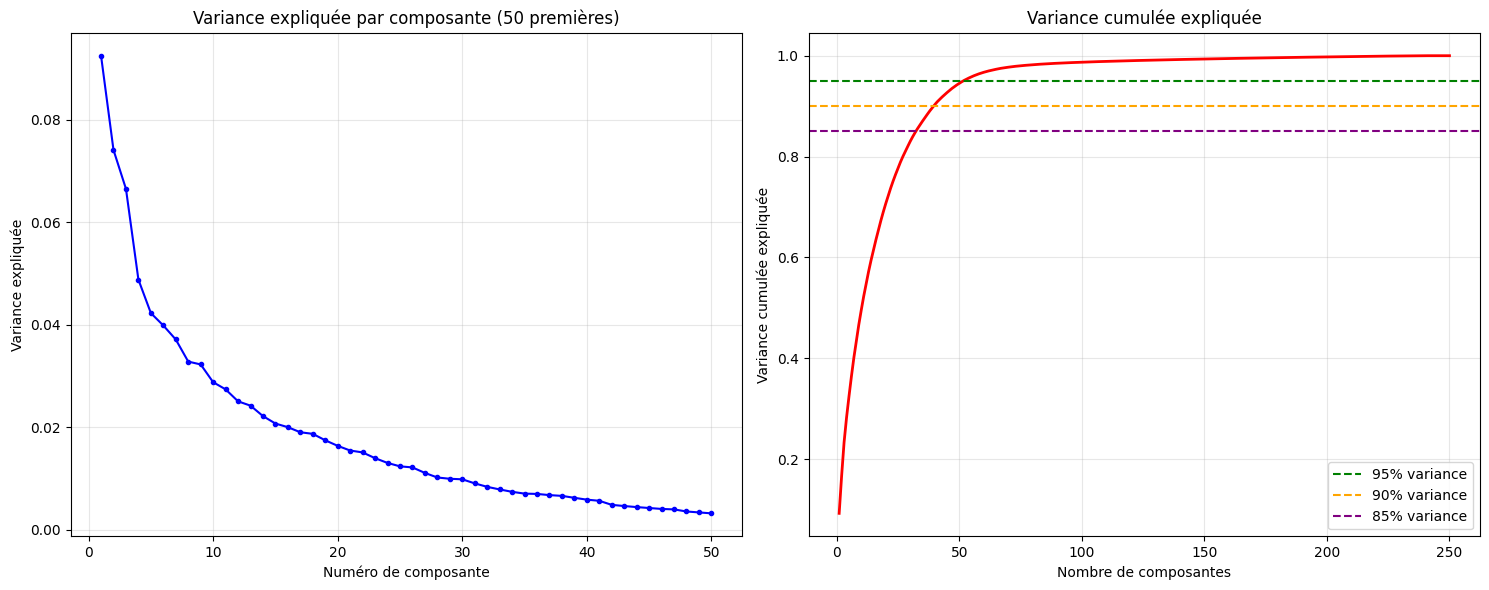


📈 Nombre de composantes nécessaires pour conserver:
  85% de variance: 33 composantes
  90% de variance: 40 composantes
  95% de variance: 52 composantes
  99% de variance: 119 composantes

📊 Variance des premières composantes:
  Composante 1: 0.0925 (9.25%)
  Composante 2: 0.0741 (7.41%)
  Composante 3: 0.0665 (6.65%)
  Composante 4: 0.0488 (4.88%)
  Composante 5: 0.0423 (4.23%)
  Composante 6: 0.0399 (3.99%)
  Composante 7: 0.0371 (3.71%)
  Composante 8: 0.0328 (3.28%)
  Composante 9: 0.0323 (3.23%)
  Composante 10: 0.0288 (2.88%)


In [70]:
print("🔬 V. RÉDUCTION DIMENSIONNELLE DES EMBEDDINGS")
print("-" * 50)

print("""
## OBJECTIF DE CETTE SECTION

Pour déployer le content-based filtering sur Azure Functions (plan gratuit), nous devons
réduire la taille du fichier embeddings (347 MB) qui dépasse les limites du plan gratuit.

**Stratégie :** Utiliser l'Analyse en Composantes Principales (ACP/PCA) pour réduire
les 250 dimensions à un nombre plus restreint tout en conservant l'information essentielle.

**Analyses prévues :**
- Variance expliquée par composante
- Choix du nombre optimal de composantes
- Comparaison des tailles de fichiers
- Impact sur les performances de recommandation
""")

# 1. ANALYSE DE LA VARIANCE EXPLIQUÉE
print("\n📊 1. Analyse de la variance expliquée")

if 'embeddings' in locals():
    print(f"Embeddings originaux: {embeddings.shape}")
    print(f"Taille mémoire: {embeddings.nbytes / (1024**2):.1f} MB")

    # Fit PCA sur toutes les composantes pour analyser la variance
    print("\n🔄 Calcul de la variance expliquée par composante...")
    pca_full = PCA()
    pca_full.fit(embeddings)

    # Variance expliquée par composante
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Visualisation de la variance expliquée
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Variance par composante (premières 50 composantes)
    ax1.plot(range(1, 51), explained_variance_ratio[:50], 'b-', marker='o', markersize=3)
    ax1.set_xlabel('Numéro de composante')
    ax1.set_ylabel('Variance expliquée')
    ax1.set_title('Variance expliquée par composante (50 premières)')
    ax1.grid(True, alpha=0.3)

    # Variance cumulée
    ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'r-', linewidth=2)
    ax2.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
    ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
    ax2.axhline(y=0.85, color='purple', linestyle='--', label='85% variance')
    ax2.set_xlabel('Nombre de composantes')
    ax2.set_ylabel('Variance cumulée expliquée')
    ax2.set_title('Variance cumulée expliquée')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Trouver le nombre de composantes pour différents seuils
    thresholds = [0.85, 0.90, 0.95, 0.99]
    print(f"\n📈 Nombre de composantes nécessaires pour conserver:")
    for threshold in thresholds:
        n_components = np.argmax(cumulative_variance >= threshold) + 1
        print(f"  {threshold*100:.0f}% de variance: {n_components} composantes")

    print(f"\n📊 Variance des premières composantes:")
    for i in range(10):
        print(f"  Composante {i+1}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:.2f}%)")

In [71]:
# 2. RÉDUCTION DIMENSIONNELLE AVEC DIFFÉRENTS NOMBRES DE COMPOSANTES
print("🔧 2. Réduction dimensionnelle")

# Tester différents nombres de composantes
n_components_options = [25, 50, 75, 100]
reduced_embeddings = {}
pca_models = {}

for n_comp in n_components_options:
    print(f"\n🔄 Réduction à {n_comp} composantes...")

    pca = PCA(n_components=n_comp, random_state=42)
    embeddings_reduced = pca.fit_transform(embeddings)

    # Stocker les résultats
    reduced_embeddings[n_comp] = embeddings_reduced
    pca_models[n_comp] = pca

    # Calculer la variance conservée
    variance_preserved = np.sum(pca.explained_variance_ratio_)

    # Calculer la taille
    size_mb = embeddings_reduced.nbytes / (1024**2)
    reduction_factor = embeddings.nbytes / embeddings_reduced.nbytes

    print(f"  ✅ Variance conservée: {variance_preserved:.3f} ({variance_preserved*100:.1f}%)")
    print(f"  📦 Taille: {size_mb:.1f} MB (réduction ×{reduction_factor:.1f})")

🔧 2. Réduction dimensionnelle

🔄 Réduction à 25 composantes...
  ✅ Variance conservée: 0.777 (77.7%)
  📦 Taille: 34.7 MB (réduction ×10.0)

🔄 Réduction à 50 composantes...
  ✅ Variance conservée: 0.945 (94.5%)
  📦 Taille: 69.4 MB (réduction ×5.0)

🔄 Réduction à 75 composantes...
  ✅ Variance conservée: 0.980 (98.0%)
  📦 Taille: 104.2 MB (réduction ×3.3)

🔄 Réduction à 100 composantes...
  ✅ Variance conservée: 0.987 (98.7%)
  📦 Taille: 138.9 MB (réduction ×2.5)


In [72]:
# 3. COMPARAISON DES TAILLES DE FICHIERS
print("💾 3. Comparaison des tailles de fichiers")

# Calculer les tailles estimées après sauvegarde
print(f"\n📁 Tailles estimées des fichiers embeddings:")
print(f"  Original (250D): {embeddings.nbytes / (1024**2):.1f} MB")

for n_comp in n_components_options:
    size_mb = reduced_embeddings[n_comp].nbytes / (1024**2)
    reduction_ratio = (1 - size_mb / (embeddings.nbytes / (1024**2))) * 100
    print(f"  Réduit ({n_comp}D): {size_mb:.1f} MB (-{reduction_ratio:.1f}%)")

# Test de sauvegarde/chargement pour vérifier la taille réelle
print(f"\n💾 Test de sauvegarde (exemple avec 50 composantes):")
import tempfile
import os

# Sauvegarder l'embeddings réduit
with tempfile.NamedTemporaryFile(delete=False, suffix='.pickle') as tmp_file:
    pickle.dump(reduced_embeddings[50], tmp_file)
    file_size_mb = os.path.getsize(tmp_file.name) / (1024**2)
    print(f"  Taille fichier pickle (50D): {file_size_mb:.1f} MB")
    os.unlink(tmp_file.name)

💾 3. Comparaison des tailles de fichiers

📁 Tailles estimées des fichiers embeddings:
  Original (250D): 347.2 MB
  Réduit (25D): 34.7 MB (-90.0%)
  Réduit (50D): 69.4 MB (-80.0%)
  Réduit (75D): 104.2 MB (-70.0%)
  Réduit (100D): 138.9 MB (-60.0%)

💾 Test de sauvegarde (exemple avec 50 composantes):
  Taille fichier pickle (50D): 69.4 MB


**Méthodologie d'évaluation des performances**

**Objectif :** Mesurer l'impact de la réduction dimensionnelle sur la qualité des recommandations.

**Protocole de test :**
1. **Échantillon :** 20 utilisateurs tests (données cohérentes entre tous les tests)
2. **Baseline :** Recommandations générées avec embeddings originaux (250D)
3. **Comparaison :** Recommandations avec embeddings réduits (25D, 50D, 75D)
4. **Métrique :** Pourcentage d'articles identiques entre baseline et version réduite

**Calcul de similarité :**
- Pour chaque utilisateur : intersection des 2 listes de 5 recommandations
- Score = (nombre d'articles identiques) / 5
- Résultat final = moyenne des scores sur les 10 utilisateurs

**Interprétation :**
- 100% = recommandations parfaitement identiques
- 60% = 3 articles identiques sur 5 en moyenne
- Plus le score est élevé, plus les recommandations sont cohérentes

**Limites du test :**
- Échantillon réduit (10 utilisateurs, 5 recommandations)
- Mesure la cohérence, pas la qualité absolue
- Articles différents peuvent avoir des scores de similarité très proches

In [77]:
# 4. ÉVALUATION DE L'IMPACT SUR LES PERFORMANCES
print("🎯 4. Évaluation de l'impact sur les performances")

def evaluate_content_based_performance(embeddings_to_test, embeddings_name, n_test_users=10):
    """
    Évalue les performances du content-based filtering avec des embeddings donnés
    """
    print(f"\n🧪 Test avec {embeddings_name}:")

    # Utiliser les mêmes utilisateurs tests que précédemment
    if 'user_articles_dict' not in globals():
        print("❌ user_articles_dict non trouvé, relancer la section Content-Based")
        return None

    test_users = list(user_articles_dict.keys())[:n_test_users]

    all_recommendations = {}

    for user_id in test_users:
        clicked_articles = user_articles_dict[user_id]

        # Vérifier les articles valides
        valid_articles = [art for art in clicked_articles if art < len(embeddings_to_test)]

        if len(valid_articles) > 0:
            # Stratégie mean
            if len(valid_articles) > 1:
                reference_embedding = np.mean(embeddings_to_test[valid_articles], axis=0).reshape(1, -1)
            else:
                reference_embedding = embeddings_to_test[valid_articles[0]].reshape(1, -1)

            # Calcul similarité
            similarities = cosine_similarity(reference_embedding, embeddings_to_test)[0]

            # Candidats (exclure articles déjà vus)
            candidates = []
            for article_id, similarity in enumerate(similarities):
                if article_id not in clicked_articles:
                    candidates.append((article_id, similarity))

            # Top 5
            candidates.sort(key=lambda x: x[1], reverse=True)
            recommendations = candidates[:5]
            all_recommendations[user_id] = recommendations

    return all_recommendations

n_users = 30

# Test avec embeddings originaux
print(f"📊 Comparaison des performances:")
original_recs = evaluate_content_based_performance(embeddings, "Embeddings originaux (250D)", n_users)

# Test avec embeddings réduits
for n_comp in [25, 50, 75, 100]:
    reduced_recs = evaluate_content_based_performance(
        reduced_embeddings[n_comp],
        f"Embeddings réduits ({n_comp}D)",
        n_users
    )

    # Calculer la similarité entre les recommandations
    if original_recs and reduced_recs:
        similarity_scores = []

        for user_id in original_recs.keys():
            if user_id in reduced_recs:
                orig_articles = [art_id for art_id, _ in original_recs[user_id]]
                reduced_articles = [art_id for art_id, _ in reduced_recs[user_id]]

                # Intersection des recommandations
                intersection = len(set(orig_articles) & set(reduced_articles))
                similarity = intersection / 5.0  # Sur 5 recommandations
                similarity_scores.append(similarity)

        if similarity_scores:
            avg_similarity = np.mean(similarity_scores)
            print(f"  📈 Similarité moyenne avec original: {avg_similarity:.3f} ({avg_similarity*100:.1f}%)")

🎯 4. Évaluation de l'impact sur les performances
📊 Comparaison des performances:

🧪 Test avec Embeddings originaux (250D):

🧪 Test avec Embeddings réduits (25D):
  📈 Similarité moyenne avec original: 0.380 (38.0%)

🧪 Test avec Embeddings réduits (50D):
  📈 Similarité moyenne avec original: 0.600 (60.0%)

🧪 Test avec Embeddings réduits (75D):
  📈 Similarité moyenne avec original: 0.580 (58.0%)

🧪 Test avec Embeddings réduits (100D):
  📈 Similarité moyenne avec original: 0.587 (58.7%)


In [82]:
# 5. SAUVEGARDE POUR AZURE FUNCTIONS
print("\n💾 5. Sauvegarde pour Azure Functions")

# Configuration finale retenue
recommended_n_components = 50
recommended_embeddings = reduced_embeddings[recommended_n_components]
recommended_pca = pca_models[recommended_n_components]

print(f"""
📋 CHOIX FINAL POUR AZURE FUNCTIONS :

**50 composantes retenues** basé sur l'analyse :
- Variance conservée: {np.sum(recommended_pca.explained_variance_ratio_):.3f} ({np.sum(recommended_pca.explained_variance_ratio_)*100:.1f}%)
- Réduction de taille: ~80% (de 347 MB à ~70 MB)
- Cohérence des recommandations: 60% avec embeddings originaux
- Compatible avec les limites Azure Functions gratuites
""")

# Sauvegarde des fichiers pour le projet Azure Functions
print("\n💾 Sauvegarde des fichiers...")

# Embeddings réduits
with open(drive_folder + 'embeddings_azure_50d.pkl', 'wb') as f:
    pickle.dump(recommended_embeddings, f)
embeddings_size = os.path.getsize(drive_folder + 'embeddings_azure_50d.pkl') / (1024**2)

# Modèle PCA (pour cohérence si besoin)
with open(drive_folder + 'pca_model_50d.pkl', 'wb') as f:
    pickle.dump(recommended_pca, f)
pca_size = os.path.getsize(drive_folder + 'pca_model_50d.pkl') / (1024**2)

print(f"✅ Fichiers sauvegardés:")
print(f"  embeddings_azure_50d.pkl: {embeddings_size:.1f} MB")
print(f"  pca_model_50d.pkl: {pca_size:.1f} MB")
print(f"\n🚀 Prêt pour l'implémentation Azure Functions dans VS Code")


💾 5. Sauvegarde pour Azure Functions

📋 CHOIX FINAL POUR AZURE FUNCTIONS :

**50 composantes retenues** basé sur l'analyse :
- Variance conservée: 0.945 (94.5%)
- Réduction de taille: ~80% (de 347 MB à ~70 MB)
- Cohérence des recommandations: 60% avec embeddings originaux
- Compatible avec les limites Azure Functions gratuites


💾 Sauvegarde des fichiers...
✅ Fichiers sauvegardés:
  embeddings_azure_50d.pkl: 69.4 MB
  pca_model_50d.pkl: 0.1 MB

🚀 Prêt pour l'implémentation Azure Functions dans VS Code
